Overlay soil samples with covariates

In [1]:
#Load the dataset soil OC 
import os
import pandas as pd
import numpy as np
import geopandas as gpd
#Load the dataset

os.chdir('C:/Negar/DSM_Sweden')  # Change to your working directory
file_path = 'Natjord/Nationell_jordartskartering.xlsx'  # Replace with your file path
soildata = pd.read_excel(file_path, sheet_name='Mätvärden Åkermark och gröda')
print(soildata.head())
# Create a GeoDataFrame
geometry = gpd.points_from_xy(soildata['Stationskoordinat E/Y'], soildata['Stationskoordinat N/X'])
print(geometry.crs)
soildata = gpd.GeoDataFrame(soildata, geometry=geometry, crs='EPSG:3006')  # Set the CRS to WGS84
#print(soildata.head())

#List all static covariates
#Overlay points with static covariates

   Nationellt övervakningsstations-ID  Nationellt provplats-ID ProvplatsId  \
0                                 NaN                      NaN     10002-4   
1                                 NaN                      NaN     10003-2   
2                                 NaN                      NaN     10004-0   
3                                 NaN                      NaN     10005-7   
4                                 NaN                      NaN     10006-5   

   Stationskoordinat N/X  Stationskoordinat E/Y  Noggrannhet (+/- m)  \
0                6530960                 526337                  NaN   
1                6460310                 372221                  NaN   
2                6602316                 621417                  NaN   
3                6480786                 508909                  NaN   
4                6234440                 472917                  NaN   

  Koordinatsystem  EU ID, provplatsnivå Provtagningsmedium  Provmaterial  ...  \
0    SWEREF 99 TM

 check if the points are in the correct CRS. To do so, we import the shp file of Sweden and map the points on the map

crs of SE_shp EPSG:3035
crs of soildata EPSG:3035


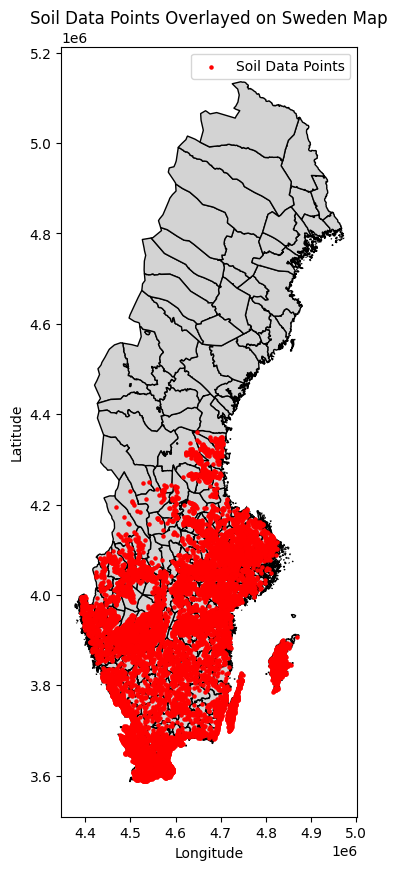

In [2]:
SE_border = 'C:/Negar/Soil_DistrictsPaper/On_soil_districts/SE_10/10_SC1.shp'
SE_shp = gpd.read_file(SE_border)
print('crs of SE_shp',SE_shp.crs)

# Ensure the CRS of soildata matches the shapefile
soildata = soildata.to_crs(SE_shp.crs)
print('crs of soildata',soildata.crs)

#plot the points on the map
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))    
SE_shp.plot(ax=ax, color='lightgrey', edgecolor='black')
soildata.plot(ax=ax, color='red', markersize=5, label='Soil Data Points')
plt.title('Soil Data Points Overlayed on Sweden Map')   
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

List the static covariates

In [ ]:
covariate_urls = [
    "https://s3.ecodatacube.eu/arco/dfme_edtm_m_30m_s_20000101_20221231_eu_epsg.3035_v20241230.tif",
    "https://s3.ecodatacube.eu/arco/geomorphon_edtm_m_30m_s_20000101_20221231_eu_epsg.3035_v20241230.tif",
    "https://s3.ecodatacube.eu/arco/hillshade_edtm_m_30m_s_20000101_20221231_eu_epsg.3035_v20241230.tif",
    "https://s3.ecodatacube.eu/arco/ls.factor_edtm_m_30m_s_20000101_20221231_eu_epsg.3035_v20241230.tif",
    "https://s3.ecodatacube.eu/arco/maxic_edtm_m_30m_s_20000101_20221231_eu_epsg.3035_v20241230.tif",
    "https://s3.ecodatacube.eu/arco/minic_edtm_m_30m_s_20000101_20221231_eu_epsg.3035_v20241230.tif",
    "https://s3.ecodatacube.eu/arco/neg.openness_edtm_m_30m_s_20000101_20221231_eu_epsg.3035_v20241230.tif",
    "https://s3.ecodatacube.eu/arco/pos.openness_edtm_m_30m_s_20000101_20221231_eu_epsg.3035_v20241230.tif",
    "https://s3.ecodatacube.eu/arco/pro.curv_edtm_m_30m_s_20000101_20221231_eu_epsg.3035_v20241230.tif",
    "https://s3.ecodatacube.eu/arco/shpindx_edtm_m_30m_s_20000101_20221231_eu_epsg.3035_v20241230.tif",
    "https://s3.ecodatacube.eu/arco/slope.in.degree_edtm_m_30m_s_20000101_20221231_eu_epsg.3035_v20241230.tif",
    "https://s3.ecodatacube.eu/arco/twi_edtm_m_30m_s_20000101_20221231_eu_epsg.3035_v20241230.tif",
    "https://s3.ecodatacube.eu/arco/crop.type_eucropmap.v1_c_10m_s_20220101_20221231_eu_epsg.3035_v20250416.tif"
]

Extract the points from static raster layers

In [4]:
import rasterio
import numpy as np

results = soildata.copy()

for url in covariate_urls:
    covariate_name = url.split("/")[-1].split(".tif")[0]

    # Keep only the first part
    parts = covariate_name.split("_")
    simplified_name = "_".join(parts[:2])
    print(f"Processing: {simplified_name}")

    with rasterio.open(url) as src:
        # Reproject points if needed
        if soildata.crs != src.crs:
            points_proj = soildata.to_crs(src.crs)
        else:
            points_proj = soildata

        # Prepare list of (x, y) coordinates
        coords = [(point.x, point.y) for point in points_proj.geometry]

        # Sample raster at points
        values = []
        for val in src.sample(coords):
            v = val[0]
            if v == src.nodata or v is None:
                v = np.nan
            values.append(v)

        # Add column to DataFrame
        results[simplified_name] = values

print("✅ Extraction completed!")
print(results.head())

Processing: crop.type_eucropmap.v1
✅ Extraction completed!
   Nationellt övervakningsstations-ID  Nationellt provplats-ID ProvplatsId  \
0                                 NaN                      NaN     10002-4   
1                                 NaN                      NaN     10003-2   
2                                 NaN                      NaN     10004-0   
3                                 NaN                      NaN     10005-7   
4                                 NaN                      NaN     10006-5   

   Stationskoordinat N/X  Stationskoordinat E/Y  Noggrannhet (+/- m)  \
0                6530960                 526337                  NaN   
1                6460310                 372221                  NaN   
2                6602316                 621417                  NaN   
3                6480786                 508909                  NaN   
4                6234440                 472917                  NaN   

  Koordinatsystem  EU ID, provplatsnivå

In [ ]:
#save the results to a new CSV file
output_file = 'output/national_soildata_with_static_covariates.csv'
#output_file = 'output/croptype.csv'
results.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")

Results saved to output/croptype.csv


Now work with Time series data, and take the average of the month or years


In [ ]:
import time
import rasterio
from pystac_client import Client
from shapely.geometry import Point
import pystac

# -------------------------------
stac_ecodatacube_url = "https://s3.ecodatacube.eu/arco/stac/catalog.json"
catalog = Client.open(stac_ecodatacube_url)
# -------------------------------
# 2. Define the covariates and their URLs
covariates = {
    #"CHELSA_Monthly_Precip": "accum.precipitation_chelsa.montlhy",
    #"ERA5_Monthly_Temp": "clm_air.temp_era5.copernicus",
    #"EVI_Bimonthly": "evi_glad.landsat.ard2.seasconv",
    #"NDSI_Bimonthly": "ndsi_glad.landsat.ard2.seasconv",
    #"SAVI_Bimonthly": "savi_glad.landsat.ard2.seasconv",
    #BSF_Yearly": "bsf_glad.landsat.ard2.seasconv.m.yearly",
    #"NDVI_Yearly": "ndvi_glad.landsat.ard2.seasconv.m.yearly",
    #"NIR_Yearly": "nir_glad.landsat.ard2.seasconv.m.yearly",
    #"NDWI_Yearly": "ndwi.gao_glad.landsat.ard2.seasconv.m.yearly",
    #"NDTI_Yearly": "ndti_glad.landsat.ard2.seasconv.m.yearly",
    #"Red_Yearly": "red_glad.landsat.ard2.seasconv.m.yearly",
    #"SWIR2_Yearly": "swir2_glad.landsat.ard2.seasconv.m.yearly",
    #"SWIR1_Yearly": "swir1_glad.landsat.ard2.seasconv.m.yearly",
    #"Green_Yearly": "green_glad.landsat.ard2.seasconv.m.yearly",
    #"Blue_Yearly": "blue_glad.landsat.ard2.seasconv.m.yearly,
    "CDR_Yearly": "cdr_glad.landsat.seasconv"
}
media_types = [pystac.MediaType.GEOTIFF, pystac.MediaType.COG]

# -------------------------------
# 3. Loop through each covariate collection
# -------------------------------
resultresults = soildata.copy()

for cov_name, collection_id in covariates.items():
    print(f"Processing: {cov_name}")

    # Fetch collection from main catalog
    try:
        collection = catalog.get_child(collection_id)
        if collection is None:
            print(f"⚠️ Collection '{collection_id}' not found, skipping.")
            results[cov_name] = np.nan
            continue
    except Exception as e:
        print(f"⚠️ Error fetching collection '{collection_id}': {e}")
        results[cov_name] = np.nan
        continue

    # Fetch raster URLs
    raster_urls = []
    for collection_item in collection.get_all_items():
        for item_id, asset in collection_item.get_assets().items():
            if asset.media_type in media_types:
                raster_urls.append(asset.href)

    print(f"  Found {len(raster_urls)} raster files.")

    if not raster_urls:
        results[cov_name] = np.nan
        continue

    # -------------------------------
    # 5. Loop through each raster URL
    # -------------------------------
    all_time_values = []

    for idx, raster_url in enumerate(raster_urls):
        print(f"  ➡️ Processing raster {idx+1}/{len(raster_urls)}: {raster_url}")
        start_time = time.time()

        try:
            with rasterio.Env(GDAL_HTTP_TIMEOUT='60'):  # Add a timeout
                with rasterio.open(raster_url) as src:
                    if soildata.crs != src.crs:
                        points_proj = soildata.to_crs(src.crs)
                    else:
                        points_proj = soildata

                    coords = [(point.x, point.y) for point in points_proj.geometry]

                    values = []
                    for val in src.sample(coords):
                        v = val[0]
                        if v == src.nodata or v is None:
                            v = np.nan
                        values.append(v)

                    all_time_values.append(values)

            duration = time.time() - start_time
            print(f"    ⏱️ Finished in {duration:.2f} seconds")

        except Exception as e:
            print(f"  ⚠️ Error reading {raster_url}: {e}")
            continue

    if all_time_values:
        all_time_values = np.array(all_time_values)
        mean_values = np.nanmean(all_time_values, axis=0)
        results[cov_name] = mean_values
    else:
        results[cov_name] = np.nan

print("✅ All covariates extracted.")

In [7]:
#save the results to a new CSV file
#output_file_time = 'output/national_soildata_with_time_covariates2.csv'
output_file_time = 'output/CDR.csv'
results.to_csv(output_file_time, index=False)
print(f"Results saved to {output_file_time}")

Results saved to output/CDR.csv


List tif layers from SGU and extract points

In [3]:
sgu_tif = ['SGU/bergart_rock_type.tif',
           'SGU/jordartskarta_ytlager_jy1.tif',
           'SGU/litotektonisk_enhet.tif']

In [4]:
# Extract points from SGU tif layers
import rasterio
import numpy as np

results_sgu = soildata.copy()

# Loop through each raster
for tif_path in sgu_tif:
    with rasterio.open(tif_path) as src:
        # Reproject points if needed
        if soildata.crs != src.crs:
            points_proj = soildata.to_crs(src.crs)
        else:
            points_proj = soildata

        # Prepare coordinates
        coords = [(point.x, point.y) for point in points_proj.geometry]

        # Sample raster values at point locations
        values = []
        for val in src.sample(coords):
            v = val[0]
            if v == src.nodata or v is None:
                v = np.nan
            values.append(v)

        # Extract a short name for column (from filename)
        colname = os.path.splitext(os.path.basename(tif_path))[0]

        # Add to DataFrame
        results_sgu[colname] = values

print("✅ SGU raster values extracted successfully.")
print(results_sgu.head())

✅ SGU raster values extracted successfully.
   Nationellt övervakningsstations-ID  Nationellt provplats-ID ProvplatsId  \
0                                 NaN                      NaN     10002-4   
1                                 NaN                      NaN     10003-2   
2                                 NaN                      NaN     10004-0   
3                                 NaN                      NaN     10005-7   
4                                 NaN                      NaN     10006-5   

   Stationskoordinat N/X  Stationskoordinat E/Y  Noggrannhet (+/- m)  \
0                6530960                 526337                  NaN   
1                6460310                 372221                  NaN   
2                6602316                 621417                  NaN   
3                6480786                 508909                  NaN   
4                6234440                 472917                  NaN   

  Koordinatsystem  EU ID, provplatsnivå Provtagningsme

In [5]:
# Save the results to a new CSV file
output_file_sgu = 'output/national_soildata_with_sgu_covariates.csv'
results_sgu.to_csv(output_file_sgu, index=False)